# Analysis of Soil Moisture at USFS Rangeland Monitoring Sites using Python
*Author: ORNL DAAC*  
*Date: Apr. 21, 2019*  
*Contact for ORNL DAAC: uso@daac.ornl.gov*

## Summary
Forests in the western U.S. have been more and more affected by drought. For example, there was a severe drought event in the Kaibab National Forest in late 2017. The lack of precipitation on Kaibab National Forest has made 2017-2018 the second driest winter in the past 25 years. It significantly affected the biomass productivity in following years. 

<img src="https://westernnews.media.clients.ellingtoncms.com/img/photos/2018/02/20/Boundary_Fire_t715.jpg"/>

*Image source: https://www.williamsnews.com/news/2018/feb/20/dry-winter-sparks-fire-fears/*

In this tutorial, we will dynamically access soil moisture data of multiple sources (i.e. satellite, airborne, and in-situ observations) in the past 10 years from the ORNL DAAC's Soil Moisture Visualizer (https://airmoss.ornl.gov/visualize/) at selected USFS rangeland monitoring sites. We then analyze the time series trends of both surface- and rootzone-level soil moisture at the monitoring sites and compare with the time series trends of the larger USFS Regions. We will also analyze the monthly cycle of soil moisture at those rangeland monitoring sites in years 2017/2018 and compare with the historical mean monthly cycle during 2010-2016.

<img src="https://www.dropbox.com/s/33dkbz8m6tidzhy/DAAC_logo_blue_text_transparent_bg_web_0.png?dl=1" width="500"/>

The Oak Ridge National Laboratory Distributed Active Archive Center (ORNL DAAC, https://daac.ornl.gov) for biogeochemical dynamics is one of the NASA Earth Observing System Data and Information System (EOSDIS, https://earthdata.nasa.gov/about) data centers managed by the Earth Science Data and Information System (ESDIS) Project, which is responsible for providing scientific and other users access to data from NASA's Earth Science Missions. ORNL DAAC is operated by the ORNL Environmental Sciences Division and is responsible for data archival, product development and distribution, and user support for biogeochemical and ecological data and models.

ORNL DAAC archives and publishes datasets of multiple science themes collected and created by a number of NASA science missions, including the Carbon Monitoring System (CMS), Arctic-Boreal Vulnerability Experiment (ABoVE), Global Ecosystem Dynamics Investigation (GEDI) (*L3 & L4 products*), and Earth Venture Suborbital missions (CARVE, AirMOSS, ACT-America, and ATom): https://daac.ornl.gov/get_data/. 


## Authenticate with Earthdata Login

A NASA Earthdata account is required to access data through the Soil Moisture Visualizer (SMV). Running the cell below will prompt you for your username and password. Go to the link to register an account:

In [ ]:
from ursjupyter import *

## Datasets

Two data layers from the US Forest Service:
* Forest Service Rangeland Monitoring Sites
* [Forest Service Regional Boundaries](https://enterprisecontent-usfs.opendata.arcgis.com/datasets/d5f88e90e2dd4e86b65ab51f8fe174a6_1)

Both data layers were converted from Shapefile to GeoJSON format with the GDAL/OGR [ogr2ogr](https://www.gdal.org/ogr2ogr.html) utility by OSGeo:
```
ogr2ogr -f geojson <output>.json <input>.shp
```

**SMV datasets are explained later.**

## Choose a USFS site
Click a USFS study site to submit a series of download requests to the SMV. 

In [1]:
%matplotlib inline
from smvjupyter import *                                       # import the UI

usfs_sites = "docs/usfs_sites/Sites_lf_geo.json"               # USFS sites
usfs_regions = "docs/usfs_admin/USFS_Regional_Boundaries.json" # admin regions

app = JupyterSMV(usfs_sites)                 # init UI , anc=usfs_regions
app.ui                                                         # display UI

### Select some plot settings and grab the (merged) dataset that you just downloaded:

In [55]:
plt.rc("font", **{"family": "normal", "weight": "bold", "size": 12})
plt.rc("axes", **{"xmargin": 0.01})

selected_layer = app.layers.iloc[app.selected]
xrdataset = selected_layer.xr
xrdataset

<xarray.Dataset>
Dimensions:                     (sample: 18, stat: 3, time: 6179)
Coordinates:
  * time                        (time) datetime64[ns] 2002-04-01 ... 2019-03-01
  * stat                        (stat) object 'Max' 'Mean' 'Min'
  * sample                      (sample) int64 0 1 2 3 4 5 ... 12 13 14 15 16 17
    lat                         (sample) float64 31.83 31.75 ... 31.34 31.34
    lon                         (sample) float64 -110.4 -110.4 ... -110.4 -110.3
Data variables:
    SoilSCAPE_surface           (sample, time, stat) float64 nan nan ... nan nan
    SoilSCAPE_rootzone          (sample, time, stat) float64 nan nan ... nan nan
    AirMOSS_L2_3_surface        (sample, time, stat) float64 nan nan ... nan nan
    AirMOSS_L2_3_rootzone       (sample, time, stat) float64 nan nan ... nan nan
    AirMOSS_L4_rootzone         (sample, time, stat) float64 nan nan ... nan nan
    SMAP_surface                (sample, time, stat) float64 nan nan ... nan nan
    SMAP_rootzone 

<Figure size 432x288 with 0 Axes>

## Soil Moisture Visualizer (SMV) datasets

### Soil Moisture Active Passive (SMAP)
Four SMAP datasets are available through the Soil Moisture Visualizer (SMV):
* Root zone (0-100cm) volumetric soil moisture (m3/m3)
* Surface zone (0-5cm) volumetric soil moisture (m3/m3)
* Gross Primary Productivity (g m-2 d-1)
* Net Ecosystem Exchange (g m-2 d-1)

This plot shows the time series of SMAP datasets averaged over the 58 SMV sample locations covering the area of USFS site 1:

Text(0.5, 1.0, 'SMAP: Soil moisture at rootzone (1) and surface (2) depths; GPP and NEE (3)')

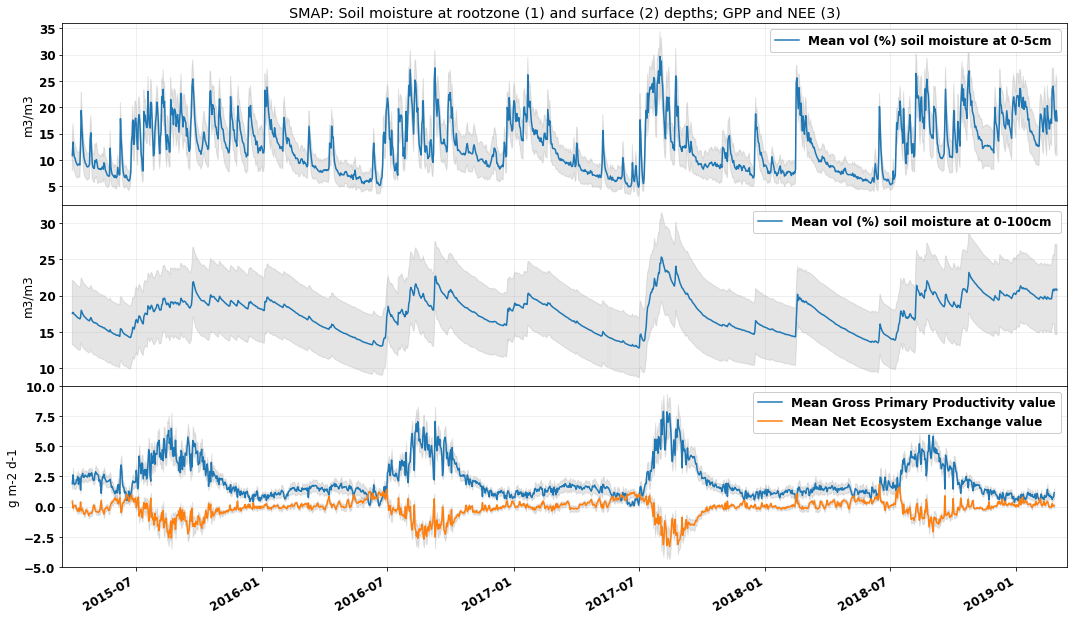

In [64]:
smap = xrdataset.filter_by_attrs(source="SMAP").sel(stat="Mean", drop=True)

fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(18, 10))
plt.subplots_adjust(hspace=0.000)

for p in [("SMAP_surface", 0), ("SMAP_rootzone", 1), ("GPP_mean", 2), ("NEE_mean", 2)]:
    ax = axs[p[1]]
    data = smap[p[0]]
    desc = data.attrs["description"]
    
    ptime = data.time.data
    pmean = data.mean("sample", keep_attrs=True)
    pstd = data.std("sample", keep_attrs=True)
    
    pmean.plot.line(x="time", ax=ax, label=desc, add_legend=False)
    ax.fill_between(ptime, (pmean-pstd), (pmean+pstd), color="gray", alpha=0.2)

for i, a in enumerate(axs):
    ylab = "m3/m3" if i<2 else "g m-2 d-1"
    a.set_ylabel(ylab)
    a.set_xlabel(None)
    a.grid('on', alpha=0.25)
    a.legend(loc=0, framealpha=1)
    
axs[0].set_title("SMAP: Soil moisture at rootzone (1) and surface (2) depths; GPP and NEE (3)")

### Airborne Microwave Observatory of Subcanopy and Subsurface (AirMOSS)

Five AirMOSS datasets are available through the SMV:
* Mean vol (%) soil moisture at 0-5 cm (from in-ground sensors)
* Mean vol (%) soil moisture at 0-100 cm (from in-ground sensors)
* Mean vol (%) soil moisture at 0 cm (from L2 airborne SAR)
* Mean vol (%) soil moisture at 0-30cm (from L2 airborne SAR)
* Mean vol (%) soil moisture at 0-100cm	(from L2 airborne SAR)

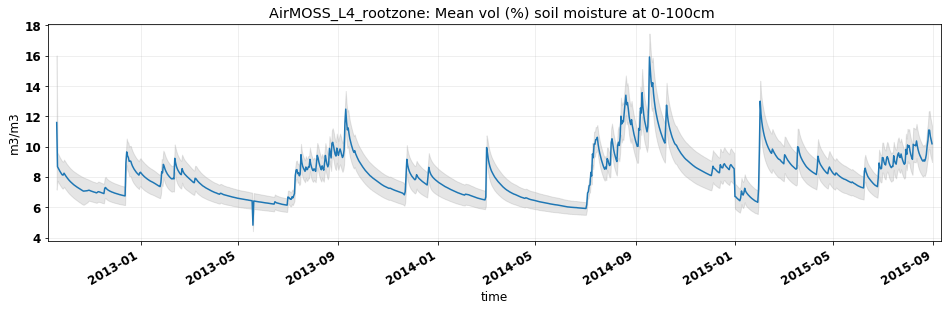

In [65]:
airmoss = xrdataset.filter_by_attrs(source="AirMOSS").sel(stat="Mean", drop=True)

data = airmoss["AirMOSS_L4_rootzone"]
ptime = data.time.data
pmean = data.mean("sample", keep_attrs=True)
pstd = data.std("sample", keep_attrs=True)

fig = plt.figure(figsize=(16, 4))
ax = plt.gca()
pmean.plot.line(x="time", ax=ax, label=desc, add_legend=False)
ax.fill_between(ptime, (pmean-pstd), (pmean+pstd), color="gray", alpha=0.2)
ax.set_title("AirMOSS_L4_rootzone: "+data.attrs["description"])
ax.set_ylabel(data.attrs["units"])
ax.grid("on", alpha=0.25)

### Daymet

Three Daymet datasets are available through the SMV: daily precipitation, minimum and maximum temperature.

Text(0.5, 1.0, 'Daymet: Surface Meteorology 2005-2010')

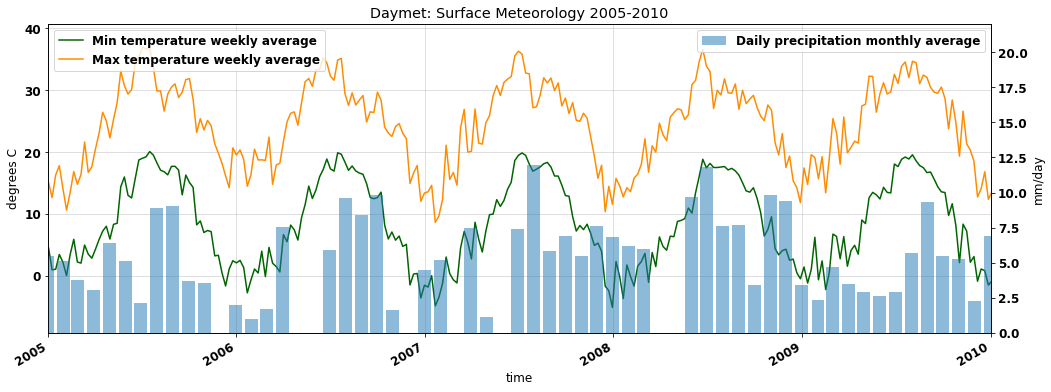

In [66]:
fig, ax0 = plt.subplots(figsize=(14,5))
fig.tight_layout()
ax1 = ax0.twinx()

daymet = xrdataset.filter_by_attrs(source="Daymet").sel(stat="Mean", drop=True)
prcp = daymet.prcp.resample(time="1m", keep_attrs=True).mean(keep_attrs=True).to_series() # avg precip over 1month
tmin = daymet.tmin.resample(time="1w", keep_attrs=True).mean(keep_attrs=True)             # avg tmin over 1week
tmax = daymet.tmax.resample(time="1w", keep_attrs=True).mean(keep_attrs=True)             # avg tmax over 1week

l1 = tmin.plot(ax=ax0, color="darkgreen", label="Min temperature weekly average")
l2 = tmax.plot(ax=ax0, color="darkorange", label="Max temperature weekly average")
ax1.bar(prcp.index, prcp, width=25, alpha=0.5, label="Daily precipitation monthly average")

ax0.grid("on", alpha=0.5)
ax0.set_xlim("2005", "2010")
ax0.set_ylabel(tmin.attrs["units"])
ax1.set_ylabel(daymet.prcp.attrs["units"])
ax0.legend(loc="upper left"); ax1.legend()
ax0.set_title("Daymet: Surface Meteorology 2005-2010")

### Rootzone and surface soil moisture
Soil moisture data are provided for two general depth zones: rootzone and surface:

Text(0.5, 1.0, 'Surface soil moisture from in situ sources')

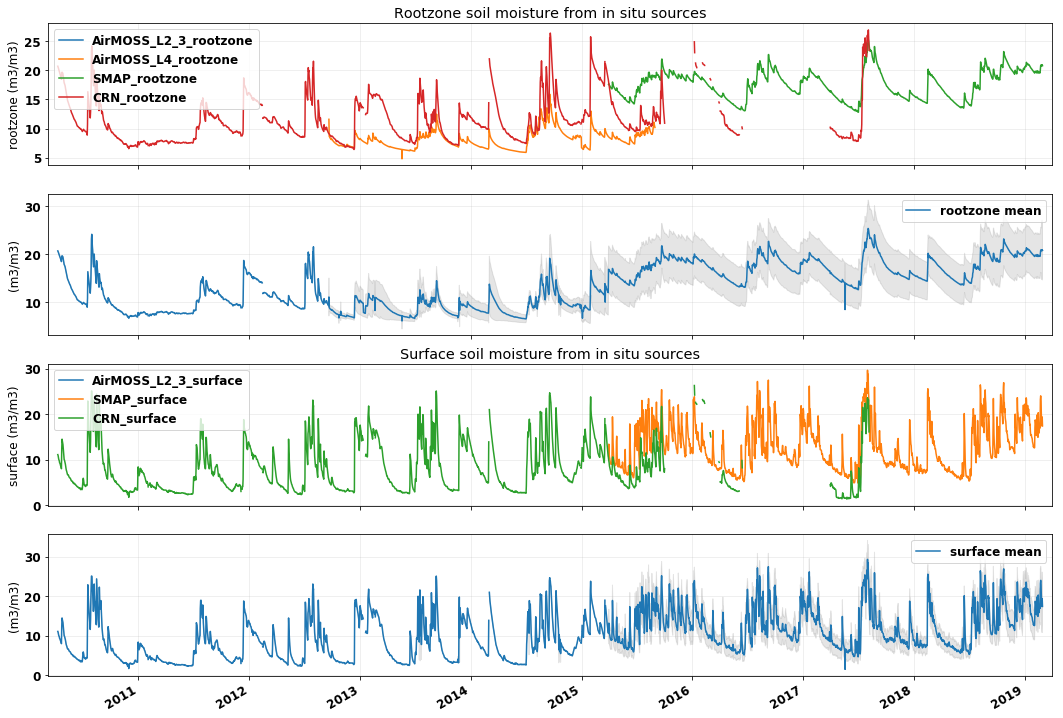

In [67]:
soil_moisture = xrdataset.filter_by_attrs(units="m3/m3").sel(stat="Mean", drop=True)
rootzone = soil_moisture.filter_by_attrs(soil_zone="rootzone")
surface = soil_moisture.filter_by_attrs(soil_zone="surface")

fig, axs = plt.subplots(nrows=4, ncols=1, sharex=True, figsize=(18, 12))

for plotter in [(0, "rootzone", rootzone), (2, "surface", surface)]:
    axa, axb = axs[plotter[0]], axs[plotter[0]+1]
    
    arrays = []
    for name, dataset in plotter[2].items():
        data = dataset.mean("sample") if "sample" in dataset.dims else dataset
        if not all(data.isnull()):
            data.plot.line(ax=axa, x="time", label=name, add_legend=False)
            arrays.append(dataset)

    stack = xr.concat(arrays, "mean").stack(cat=("mean", "sample"))
    pmean, pstd = stack.mean("cat"), stack.std("cat")
    pmean.plot(x="time", ax=axb, label=plotter[1]+" mean")
    axb.fill_between(pmean.time.data, (pmean-pstd), (pmean+pstd), color="gray", alpha=0.2)
    
    axa.set_ylabel(plotter[1]+" (m3/m3)"); axb.set_ylabel("(m3/m3)")
    axa.grid("on", alpha=0.25); axb.grid("on", alpha=0.25); 
    axa.legend(loc=2); axb.legend(loc=1)
    axa.set_xlabel(None); axb.set_xlabel(None)


axs[0].set_title("Rootzone soil moisture from in situ sources")
axs[2].set_title("Surface soil moisture from in situ sources")

# In situ, airborne soil moisture observations for all datasets
The aggregation and harmonization of the various soil moisture datasets gives flexibility for a wide range of implementation scenarios. The next cell plots the average through time of all in situ and airborne soil moisture datasets available through the SMV. The two sets of data can be selection from the big `xarray` dataset with a few methods:
* select datasets with *in situ* and *airborne* for the *type* attribute
* select the *Mean* statistic from the *stat* dimension and the desired site from the *site* dimension
* average the remaining data over the *sample* dimension

Here's how it looks in practice:

In [ ]:
mapw2, output2 = poly_mapper(selected_layer)
display(HBox([output2, mapw2]))

insitu = xrdataset.filter_by_attrs(type="in situ")              # select in situ, and
airborne = xrdataset.filter_by_attrs(type="airborne")           # airborne datasets

with output2:
    fig, axs = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(15, 8))
    plotters = [(insitu, axs[0], "In situ soil moisture"), 
                (airborne, axs[1], "Airborne soil moisture")]
    
    for p in plotters:
        data, ax, title = p
        data = data.sel(stat="Mean").mean(dim="sample")         # select stat "Mean" and site N. avg sample dim
        tmpstack = np.stack([data[v].data for v in data])       # collapse dataset into a stacked array
        tmpmean = np.nanmean(tmpstack, axis=0)                  # calculate mean over time axis (0)
        tmpstd = np.nanstd(tmpstack, axis=0)                    # calculate mean over time axis (0)
        tmptime = data.time.data
        
        ax.plot_date(x=tmptime, y=tmpmean, color="black", linestyle="solid", marker=None)
        ax.fill_between(tmptime, (tmpmean-tmpstd), (tmpmean+tmpstd), color="gray", alpha=0.2)
        ax.set_ylim(0, 30)
        ax.set_title(title+" [avg of available SMV datasets]")
        ax.set_ylabel("m3/m3")
        ax.grid('on', alpha=0.25)
    
    plt.show()

In [ ]:
mapw3, output3 = poly_mapper(selected_layer)
display(HBox([output3, mapw3]))

insitu = xrdataset.filter_by_attrs(type="in situ")              # select in situ, and
airborne = xrdataset.filter_by_attrs(type="airborne")           # airborne datasets
spaceborne = xrdataset.filter_by_attrs(type="spaceborne")           # airborne datasets


with output3:
    fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(15, 8))
    plotters = [(insitu, axs[0], "In situ soil moisture"), 
                (airborne, axs[1], "Airborne soil moisture"),
                (spaceborne, axs[2], "Spaceborne soil moisture")]
    
    for p in plotters:
        data, ax, title = p
        data = data.sel(stat="Mean").mean(dim="sample")         # select stat "Mean" and site N. avg sample dim
        tmpstack = np.stack([data[v].data for v in data])       # collapse dataset into a stacked array
        tmpmean = np.nanmean(tmpstack, axis=0)                  # calculate mean over time axis (0)
        tmpstd = np.nanstd(tmpstack, axis=0)                    # calculate mean over time axis (0)
        tmptime = data.time.data
        
        ax.plot_date(x=tmptime, y=tmpmean, color="black", linestyle="solid", marker=None)
        ax.fill_between(tmptime, (tmpmean-tmpstd), (tmpmean+tmpstd), color="gray", alpha=0.2)
        ax.set_ylim(0, 30)
        ax.set_title(title+" [avg of available SMV datasets]")
        ax.set_ylabel("m3/m3")
        ax.grid('on', alpha=0.25)
    
    plt.show()

In [ ]:
monthly = insitu.sel(stat="Mean", drop=True).mean("sample").resample(time="1m").mean() #.sel(time="time.month")
monthly2 = monthly.groupby("time.year").assign_coords().set_index(year="year")
monthly2 = monthly2.groupby("time.month").assign_coords().set_index(month="month")
monthly2 = monthly2.stack(my=("year","month"))
monthly2.isel(my=[1,2,3,4,5])["CRN_rootzone"]#.plot(x="time")

### AirMOSS datasets available through Soil Moisture Visualizer
Five AirMOSS datasets are available through the SMV:
* Mean vol (%) soil moisture at 0-5 cm (from in-ground sensors)
* Mean vol (%) soil moisture at 0-100 cm (from in-ground sensors)
* Mean vol (%) soil moisture at 0 cm (from L2 airborne SAR)
* Mean vol (%) soil moisture at 0-30cm (from L2 airborne SAR)
* Mean vol (%) soil moisture at 0-100cm	(from L2 airborne SAR)

This plot shows the time series of AirMOSS datasets averaged over the **N** SMV sample locations covering the area of USFS site 5:

In [ ]:
airborne_AirMOSS = xr_complete.filter_by_attrs(source="AirMOSS", type="airborne").sel(stat="Mean", site=9)

np.nanmean(insitu_AirMOSS["AirMOSS_in-ground_surface"].data)

In [ ]:
mapw5,output5 = poly_mapper(selected_layer)
display(HBox([mapw5, output5]))

AirMOSS = selected_layer.xr.filter_by_attrs(source="AirMOSS", type="airborne").sel(stat="Mean")

with output5:
    fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(15, 8))
    plotters = [(AirMOSS["AirMOSS_L2_3_surface"], 0, "orange"),
                (AirMOSS["AirMOSS_L2_3_rootzone"], 1, "purple"),
                (AirMOSS["AirMOSS_L4_rootzone"], 2, "green")]

    for p in plotters:
        data, line_axis, line_color = p
        plotargs = {"x": "time", "ax": axs[line_axis], "color": line_color}
        tmpmean, tmpstd = data.mean("sample"), data.std("sample")
        tmpmean.plot.line(label=data.attrs["description"], **plotargs)
        (tmpmean-tmpstd).plot.line(ls=":", alpha=0.4, **plotargs)
        (tmpmean+tmpstd).plot.line(ls=":", alpha=0.4, **plotargs)
        axs[line_axis].set_xlabel("")
        axs[line_axis].set_ylabel("m3/m3")
        axs[line_axis].set_title("AirMOSS "+data.attrs["description"])
    
    plt.show()

# Detailed walkthrough

This is an introduction...

## Requirements

### Python
Written and tested in Python3. Should be compatible with Python2 with minor changes.

#### Heavy-lifters:
* [numpy](https://www.numpy.org/) --- fundamental Python module for processing n-dimensional arrays and for scientific computing in general
* [pandas](https://pandas.pydata.org/) --- tabular data structures and analysis tools built on numpy
* [xarray](http://xarray.pydata.org/en/stable/) --- higher-level structures built on pandas (and to a lesser degree [dask](https://dask.org/)) that support labeled dimensions, coordinates, and attributes for geodata

All three above are well-supported and widely-used in Python data/geoscience communities. `numpy` provides the functionality that all array mathematics in Python is built upon; `pandas` provides familiar tabular data structures thatmake working with relational/labeled data easy and intuitive; and `xarray` provides N-dimensional variants of the core pandas data structures that *in my opinion* feel more intuitive for datasets with a spatial component than an equivalent implementation in pure `pandas`, where data would need to be represented in "long-and-narrow" form to allow for the same indexing capabilities.

#### Important, but you have other options:
* [requests](https://2.python-requests.org/en/master/) --- high-level library for sending HTTP requests; alternatives: urllib/urllib2
* [shapely](https://shapely.readthedocs.io/en/latest/project.html) --- format-agnostic library based on [GEOS](https://trac.osgeo.org/geos/) for manipulating and analyzing geometric objects
* [matplotlib](https://matplotlib.org/) --- 2D plotting; `pandas` and `xarray` have `matplotlib` functionality built-in, so we only need to borrow tools from a couple of submodules

`xarray` could also go in this category.

#### Just for fun:
* [ipywidgets](https://ipywidgets.readthedocs.io/en/stable/index.html) --- interactive HTML widgets for Jupyter Notebooks and the IPython kernel | [GitHub](https://github.com/jupyter-widgets/ipywidgets)
* [ipyleaflet](https://ipyleaflet.readthedocs.io/en/latest/) --- a Jupyter/Leaflet bridge enabling interactive maps inside  notebooks | [GitHub](https://github.com/jupyter-widgets/ipyleaflet)

After installing with *pip*, you need to enable the jupyter extensions:
```
pip install ipywidgets
pip install ipyleaflet
jupyter nbextension enable --py widgetsnbextension
```

#### Also:
* io, json --- both part of the core library; NOTE: `io.StringIO` is `StringIO.StringIO` in Python2

In [ ]:
import numpy as np                          # for everything
import pandas as pd                         # for almost everything
import xarray as xr                         # for next to almost everything

import requests                             # for downloading SMV data
from shapely.geometry import shape          # for geometry data comparison

import json                                 # for converting between JSON and Python dicts
from io import StringIO                     # for making "pseudo-files" from downloaded text

import ipywidgets as wg                     # for widgets
import ipyleaflet as mwg                    # for map widgets
import matplotlib.pyplot as plt             # for plotting
from matplotlib import cm, colors           # for generating color maps

from IPython.display import display         # for telling IPython to render some outputs

auth = dict(ORNL_DAAC_USER_NUM=str(32863))  # Jack's usernum; REMOVE

## Soil Moisture Visualizer

The [table (docs/smvdatasets.csv)](docs/smvdatasets.csv) included in this repo is a copy of the datasets table from the [SMV User Guide](https://daac.ornl.gov/soilmoisture/guide.html). Read it into a data frame using [`pandas.read_csv`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html) and display the available datasets:

In [ ]:
smv_datasets = pd.read_csv("docs/smvdatasets.csv", index_col="dataset", header=0)
smv_datasets

The datasets are updated weekly (every Sunday), but some data sets may have a longer latency period.

Start by opening an example dataset from the included [text file](docs/daily-smap-ORNL-DAAC-PccIuo.txt). We use `pandas.read_csv` again, skipping to the fourth line and setting the data frame index to the column labeled *time*:

In [ ]:
df = pd.read_csv("docs/daily-smap-ORNL-DAAC-PccIuo.txt", header=4, index_col="time")
df.index = pd.to_datetime(df.index)   

df.head(5)

The text file is parsed to a data frame with up to three values per column, delimited by semicolons `;`: min, mean, and max. Do some additional data preparation in the following steps:

1. Use [`pandas.Series.str.split`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.str.split.html) to split each column into three columns;
2. replace the empty strings with [`numpy.nan`](https://docs.scipy.org/doc/numpy-1.13.0/user/misc.html) using [`pandas.DataFrame.replace`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.replace.html); and
3. change the data type from string to float with [`pandas.DataFrame.astype`](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html). 

Then, assign column names and print the head again:

In [ ]:
data = df["AirMOSS_L4_rootzone"].str.split(";", n=2, expand=True)       # split pd column to 3
data = data.replace('', np.nan)                                         # set '' to nan
data = data.astype(float)                                               # set all to float
data.columns = ["AirMOSS_L4_rootzone_"+s for s in ["min","mean","max"]] # set column names

data.head(5)

`Pandas` repackages some basic plotting functionality from `matplotlib`. You can call `pandas.DataFrame.plot` or `pandas.Series.plot`. Plot L4 AirMOSS rootzone soil moisture from the example dataset:

In [ ]:
data["AirMOSS_L4_rootzone_mean"].plot()
data["AirMOSS_L4_rootzone_min"].plot()
data["AirMOSS_L4_rootzone_max"].plot()

---------------------------------------------
## Read USFS data from GeoJSON

The original dataset was a shapefile, but we reprojected and saved as GeoJSON using *ogr2ogr* from the GDAL/OGR binaries package available at OSGeo. GeoJSON is [a format for encoding a variety of geographic data structures](http://geojson.org/).

Let's open the GeoJSON and extract some information about one of the USFS sites. Read to a dictionary with `json.load` and print the first feature:

In [ ]:
with open("sites/Sites_lf_geo.json", "r") as f:
    shapes = json.load(f)   # json load parses open json file to dict

shapes.keys()

Inspect the first three dictionary items:

In [ ]:
print(shapes["crs"]) 
print(shapes["name"])
print(shapes["type"])

A list of geojson features is stored in the *features* element. Print the keys for the first one:

In [ ]:
features = shapes["features"]
feat = features[0]

feat.keys()

Features have two essential pieces, *geometry* and *properties*, and a third item *type* that acknowledges that the item is a feature. The geometry contains two items: *type*, one of seven possible types, and *coordinates*, a list of coordinates that delineate the feature. Here's an example:
```
 "type": "Feature",
   "geometry": {
       "type": "Polygon",
       "coordinates": [
           [
               [100.0, 0.0],
               [101.0, 0.0],
               [101.0, 1.0],
               [100.0, 1.0],
               [100.0, 0.0]
           ]
       ]
   },
```
A feature's properties are equivalent to what you'd find in the attribute table if you were to open the file in ArcMap. Print them:

In [ ]:
feat["properties"]

These values are aboveground NPP... ? Use list comprehension to collect the values for mean and standard deviation into a dictionary, and make a data frame from the dictionary:

In [ ]:
stats = pd.DataFrame({
    "mean": [v for k,v in feat["properties"].items() if "MEAN" in k],
    "std": [v for k,v in feat["properties"].items() if "STD" in k]})

stats.head(5)

Don't print the feature's geometry, it will take up the whole page. Instead pass it to `Shapely.geometry.shape`:

In [ ]:
geom = feat["geometry"]         # geometry from feature 0
sgeom = shape(geom)             # Shapely.geometry.shape
bnds = sgeom.bounds             # bounding box around geometry
cent = sgeom.centroid           # centroid for geometry

sgeom

`Shapely` provides some convenient methods for getting important spatial metadata about the feature like its centroid and bounding coordinates. We'll use these later.

For now, we learn how to render the geometry as an [`ipyleaflet`](https://ipyleaflet.readthedocs.io/en/latest/) map layer. Create the map in four steps:
1. Get a basemap and make a tile layer to display in the map widget. You have a lot of options, including layers available through NASA GIBS: `basemaps.NASAGIBS.ModisTerraTrueColorCR` | [More information](https://ipyleaflet.readthedocs.io/en/latest/api_reference/tile_layer.html)
2. [Make a map layer from the GeoJSON feature](https://ipyleaflet.readthedocs.io/en/latest/api_reference/geo_json.html) that we explored earlier.
3. Make an [`ipyleaflet.LayerGroup`](https://ipyleaflet.readthedocs.io/en/latest/api_reference/layer_group.html) to store an array of point layers that we will generate in the next step.
4. [Initialize the map widget](https://ipyleaflet.readthedocs.io/en/latest/api_reference/map.html) with a tuple of layers, the map center and zoom level.

In [ ]:
bmap = mwg.basemap_to_tiles(mwg.basemaps.Esri.WorldImagery) # 1. get a basemap
poly = mwg.GeoJSON(data=feat)                               # 2. geojson layer
points = mwg.LayerGroup()                                   # 3. points group
m1 = mwg.Map(                                               # 4. map widget init
    layers=(bmap, poly, points,),  # tuple of map layers
    center=(cent.y, cent.x),       # map center (from shapely)
    zoom=9)                        # zoom level

m1                                 # display the map

## the EASE Grid

Spatial queries to the Soil Moisture Visualizer return data corresponding to 9x9-km cells within [the EASE grid system](https://nsidc.org/data/ease).

The next short section of the notebook demonstrates how to select an array coordinates that represent centroids of  EASE grid cells that fall within the boundary of the `shapely` geometry that we created earlier. The coordinates can then be used to submit a series of requests for data from the SMV.
      
The EASE grid latitudes and longitudes are stored in two binary files:
* [docs/EASE2_M09km.lats.3856x1624x1.double](docs/EASE2_M09km.lats.3856x1624x1.double)
* [docs/EASE2_M09km.lats.3856x1624x1.double](docs/EASE2_M09km.lats.3856x1624x1.double)

Read the two files to arrays with [`numpy.fromfile`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.fromfile.html), flatten them by calling [`numpy.ndarray.flatten`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.ndarray.flatten.html), and stack them with [`numpy.dstack`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dstack.html) to make one very long 2-d array of latitude, longitude pairs:

In [ ]:
lats = np.fromfile("docs/EASE2_M09km.lats.3856x1624x1.double", dtype=np.float64).flatten() 
lons = np.fromfile("docs/EASE2_M09km.lons.3856x1624x1.double", dtype=np.float64).flatten()
crds = np.dstack((lats,lons))[0]

print("Array shape: "+str(crds.shape)); crds

Reduce the giant array using the tuple of `bnds` that we took from the `shapely` geometry earlier:

In [ ]:
ease = crds[(bnds[1]<lats)&(lats<bnds[3])&(bnds[0]<lons)&(lons<bnds[2])]

print("The new array shape: "+str(ease.shape))

So, 108 EASE grid points fall within the minimum rectangular envelope of the geometry. That seems reasonable. Make an [`ipyleaflet.CircleMarker`](https://ipyleaflet.readthedocs.io/en/latest/api_reference/circle_marker.html) for each point and display the updated map widget:

In [ ]:
for p in ease:
    pt = mwg.CircleMarker(                       # map point
        location=(p[0],p[1]),                    # lat,lon tuple
        radius=7,                                # in pixels
        stroke=False,
        fill_opacity=0.6,
        fill_color="black")
    points.add_layer(pt)
    
m1

Now we should eliminate points that fall outside of the actual boundary of the polygon. `shapely.geometry.shape` objects provide a method [`object.contains`](https://shapely.readthedocs.io/en/stable/manual.html) that returns a boolean indicating whether or not it contains an input point. The next cell does the following:
1. Clear the points that we added to the map in the last cell.
2. Make a simple function `get_point` that returns a `shapely.geometry.shape` for an input lat,lon pair.
3. Iterate over the remaining EASE grid points and add to the map widget if shapely *contains* returns True.



In [ ]:
def get_point(p):
    """Takes input lat,lon pair; returns a shapely point geometry."""
    s = shape({"coordinates": [p[1], p[0]], "type": "Point"})
    return(s)


points.clear_layers()                   # clear the map points
for p in ease:                          # loop over remaining EASE points
    
    spt = get_point([p[0], p[1]])       # get a shapely point
    if sgeom.contains(spt):             # if poly contains point, 
        
        pt = mwg.CircleMarker(          # make circle marker
            location=(p[0],p[1]),
            radius=7,
            stroke=False,
            fill_opacity=0.6,
            fill_color="black")
        
        points.add_layer(pt)            # add to map
        
m1

Make a function that includes all of the logic above:

In [ ]:
def get_ease(shapely_geom):
    """
    Takes an input shapely geometry and returns a list of EASE grid 
    lat,lon pairs that are contained within it.
    """

    bnds = shapely_geom.bounds                # bounding box of input geom
    ease = crds[
        (bnds[1]<lats) & (lats<bnds[3]) &     # ybnds < lat < ybnds
        (bnds[0]<lons) & (lons<bnds[2])]      # xbnds < lon < xbnds

    ease_reduced = []
    for p in ease:
        
        shapely_pt = shape({                  # input to shapely.shape is a
            "type": "Point",                  # python dict equivalent of
            "coordinates": (p[1], p[0])})     # geojson point geometry
        
        if shapely_geom.contains(shapely_pt): # if point inside poly
            ease_reduced.append([p[0], p[1]]) # return lat, lon tuple

    return(ease_reduced)

## Download SMV data with `requests`
Each request to SMV takes a latitude `&lt` and longitude `&ln`. This request is for (30,-100):       
https://daac.ornl.gov/cgi-bin/viz/download.pl?lt=30&ln=-100&d=smap

In [ ]:
lt, ln = ease[0]                                               # first EASE point
url = "https://daac.ornl.gov/cgi-bin/viz/download.pl?"         # SMV download url
request_url = url+"lt={lt}&ln={ln}&d=smap".format(lt=lt,ln=ln) # complete request url

print("SMV base url:\t"+url); print("Full URL:\t"+request_url)

Now use [`requests.get`](https://2.python-requests.org//en/master/user/quickstart/) (*note: use `session` from the Earthdata authentication at the very beginning of the notebook*) to download the data from the URL and print the first ten lines:

In [ ]:
r = requests.get(request_url, cookies=auth)
f = StringIO(r.text)

print("\n".join(f.readlines()[0:10]))

You can use the same methods that we covered at the beginning to parse the text to a pandas data frame. We will take that one step further in the next section as we prepare to add another dimension to our SMV dataset.

## Reformat SMV data as a netCDF-like `xarray.Dataset`

Now add one more step to the **SMV download response** > **pandas data frame** > **split columns to expanded data frame** workflow by making an xarray dataset. Start with the two functions below, `txt_to_pd` and `split_pd`. They do all of the SMV data processing that we've covered to this to point: 
* convert the request response to a text object; 
* parse the text to a `pandas` data frame; and,
* parse the columns of `min;mean;max` into three new columns.

Test them on the dataset that we downloaded before:

In [ ]:
def txt_to_pd(response_text):
    """Parses response.text to data frame with date index."""
    
    f = StringIO(response_text)                          # get file from string
    df = pd.read_csv(f, header=4, index_col="time")      # read to df
    df.index = pd.to_datetime(df.index)                  # convert index to dates
    
    return(df)


def split_pd(col):
    """Splits pd column by ; and set all values to float, nan."""
    
    df = col.str.split(";",n=2,expand=True)              # split col by ;
    df = df.replace('', np.nan)                          # set '' to nan
    df = df.astype(float)                                # set all to float
    df.columns = ["Min","Mean","Max"]                    # add column names
    
    return(df)

# ----------------------------------------------------------------------------------
#df = txt_to_pd(r.text)        <- make request auth work # parse response.text to df
# temporary, remove this, auth
df = pd.read_csv("docs/daily-smap-ORNL-DAAC-hYa36V.txt", header=4, index_col="time")
df.index = pd.to_datetime(df.index)    
# ----------------------------------------------------------------------------------

dfs = {col: split_pd(df[col]) for col in df.columns}     # loop over cols and split to dfs

The two `xarray` data structures, [`xarray.DataArray`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html#xarray.DataArray) and [`xarray.Dataset`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.html#xarray.Dataset), are so closely tied to the [`pandas.Series`](http://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.html#pandas.Series) and [`pandas.DataFrame`](http://pandas.pydata.org/pandas-docs/stable/reference/frame.html) that both modules provide methods to convert between them. 

We need to define the dimensions of our data in order to take full advantage of the features of `xarray`. We do that by making *coordinate* variables that allow for practical indexing of the data along said dimensions. For example, this cell demonstrates how to create three [`xarray.DataArrays`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.html#xarray.DataArray) that represent:
1. the sample dimension --- remember the array of EASE grid points? a dimension to describe the spatial relationship between the different sample datasets will make it easier to summarize the data going forward.
2. the latitude dimension, and
3. the longitude dimension --- these two are self-explanatory; the latitude and longitude values are arranged along the sample dimension, one pair per sample, to describe the position in space of each sample.

In [ ]:
latatts = dict(                                     # CF attributes for latitude
    standard_name="latitude",
    long_name="sample latitude",
    units="degrees_north")

lonatts = dict(                                     # CF attributes for longitude
    standard_name="latitude",
    long_name="sample latitude",
    units="degrees_north")

s = xr.DataArray(data=[1], dims=["sample"])                                  # 1. 
latarr = xr.DataArray(data=[lt], coords=[s], dims=["sample"], attrs=latatts) # 2.
lonarr = xr.DataArray(data=[ln], coords=[s], dims=["sample"], attrs=lonatts) # 3. 

latarr

The resulting latitude array is very simple, with only one value. 

The function below converts SMV outputs (as data frames) to an `xarray.DataArray` with three dimensions: the sample dimension (length=1), the time dimension (length=n), and the *stat* dimension, which really only exists because it allows us to keep all of the data in one place. Steps:

1. Collect from the SMV datasets table a list of attributes to assign to the array; 
2. convert the `pandas.DataFrame` to an the `xarray` structure; 
3. rename the automatically-generated dimension to "stat"; and, 
4. set a new attribute that indicates whether or not the dataset has valid observations; "allnan"==0 indicates there are valid data and vice versa

In [ ]:
def pd_to_xr(dataset, df):
    """Makes an xr.Dataset from a pandas column (series) and coords."""
    
    a = smv_datasets.loc[dataset].to_dict()                 # 1.
    x = xr.DataArray(df, name=dataset, attrs=a)             # 2.
    x = x.rename(dict(dim_1="stat"))                        # 3.
    x.attrs["allnan"] = int(np.isnan(np.nanmean(x.data)))   # 4.
    
    return(x)

Loop over the dictionary of data frames, here's the first one:

In [ ]:
ds = {c: pd_to_xr(c,d) for c,d in dfs.items()}
xds = xr.merge(ds.values())
xds = xds.assign_coords(lat=latarr, lon=lonarr)
xdsp = xds[""]
xds

And this is what a single SMV dataset looks like:

In [ ]:
xds["SMAP_surface"]

In some cases it may be advantageous to reorder the dimensions over which the data are arranged. You can transpose the 2-d array with [`xarray.Dataset.transpose`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.transpose.html):

```
xdsT = xds.transpose()
```

### Get the "plottable" datasets
Remember that we added an attribute to each SMV dataset that indicates whether or not the mean\*min\*max array is entirely nodata: *allnan*

Exclude SMV datasets that are entirely nodata using [`xarray.Dataset.filter_by_attrs`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.filter_by_attrs.html#xarray.Dataset.filter_by_attrs):

In [ ]:
pds = xds.filter_by_attrs(allnan=0).sel(stat="Mean")
pds

In [ ]:
pds.filter_by_attrs(units="m3/m3")

In [ ]:
units = list(set([pds[d].attrs["units"] for d in pds]))
print(units)

In [ ]:
allnan = lambda v: np.count_nonzero(~np.isnan(v.data))==0
units = [
    'g m-2 d-1', 
    'm3/m3', 
    'degrees C', 
    'mm/day']

fig, axs = plt.subplots(4, 1, sharex=True, figsize=(15, 12))

for i, unit in enumerate(units):
    
    variables = pds.filter_by_attrs(units=unit)
    for v in variables:
        if v!="COSMOS_surface":
            a = pds[v]
            if not allnan(a):              
                pds[v].plot(ax=axs[i])
                axs[i].set_title(None)
                axs[i].set_xlabel(None)

We can also filter by any of the other attribute(s) that we assigned from the SMV datasets table:

In [ ]:
pds.filter_by_attrs(source="SMAP", soil_zone="rootzone")

### Slice/filter using dimension-based criteria
Filter by the *stat* dimension:

In [ ]:
pds.sel(stat="mean")

or the *time* dimension:

In [ ]:
time = pds.time.data
print(time[10]); print(time[20])

pds.sel(time=slice(time[10],time[20]))

This feature becomes more useful as you add more dimensions to your dataset. We'll use it to filter across three dimensions once we add more sample locations to this dataset.

In [ ]:
pds["SMAP_surface"]

## Make a simple interactive plotting UI
We use the logic above to drive the plotting UI. We can get a list of the attributes to filter by using list comprehension:

In [ ]:
source = list(set([pds[d].attrs["source"] for d in pds]))
stype = list(set([pds[d].attrs["type"] for d in pds]))
soil_zone = list(set([pds[d].attrs["soil_zone"] for d in pds]))

print(source); print(stype); print(soil_zone)

GRACE has very few observations, so we don't really need the source filter. And all data are from spaceborne datasets, so the only relevant attribute filter for this dataset is the *soil_zone*:

In [ ]:
dates = pds.sel(stat="mean").dropna(dim="time", how="all").time.data
dates = dates.astype('M8[D]')

time_slider = wg.SelectionRangeSlider(
    options=dates, 
    index=(0, len(dates)-1),
    continuous_update=False,
    layout=wg.Layout(width="auto"))

widgets = dict(
    Time=time_slider, 
    By=["None", "year", "month", "week", "day"],
    Zone=['surface', 'rootzone'],
    Mean=True, Min=True, Max=True)

# needs to run twice to switch from inline -->
%matplotlib notebook

Build and display the plot ui:

In [ ]:
%matplotlib notebook
plt.rcParams['figure.figsize'] = [12, 5]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)


def update(Time, By, Zone, Mean, Min, Max):
    """ """

    stat = [True]*3 if not any([Mean,Min,Max]) else [Mean,Min,Max]
    data = pds.sel(stat=stat)                      # filter by stats
    
    data = data.filter_by_attrs(soil_zone=Zone)    # filter by attributes

    data = data.sel(time=slice(Time[0],Time[1]))   # filter by time;
    
    xaxis = "time" if By == "None" else By         # new plot interval
    if By is not "None":
        data = data.sel(stat="mean")
        data = data.groupby("time."+str(By)).mean()

    ax.clear()                                     # clear plot
    for d in data:                                 # loop over vars
        data[d].plot.line(x=xaxis, ax=ax)          # add line
    fig.canvas.draw()                              # draw 


p = wg.interactive(update, **widgets);
display(p)

## Organize a series of SMV samples into similar structure

The capabilities of xarray aren't obvious until you add a second dimension to the data (excluding the unnecessary *stats* dim). You can do everything we just did with pandas. Let's look at our USFS polygon again with a new map:

In [ ]:
points = mwg.LayerGroup()
polys = mwg.LayerGroup(layers=(poly,))
m2 = mwg.Map(layers=(polys, points, bmap), center=(cent.y, cent.x), zoom=9)

m2

### Container for point samples
`Sample(<id>,<lat>,<lon>)`
* id: an integer id unique to the sample within it's input polygon
* lat, lon: latitude, longitude numerics

In [ ]:
url = "https://daac.ornl.gov/cgi-bin/viz/download.pl?"

class Sample(object):

    def __init__(self, i, lat, lon):
        """Inits with id,lat,lon; makes request string, map point."""
        self.id, self.lat, self.lon = i, lat, lon               # id, lat, lon
        self.rurl = url+"lt={0}&ln={1}&d=smap".format(lt,ln)    # request url     
        self.pt = mwg.CircleMarker(                             # map point
            location=(lat,lon),                                 # lat,lon tuple
            radius=7,                                           # in pixels
            stroke=False,
            fill_opacity=0.6,
            fill_color="black")

    def update(self, **kwargs):
        for arg, val in kwargs.items():
            setattr(self.pt, arg, val)
        
    def submit(self):
        """Called by parent. Downloads url. Updates status."""
        self.response = requests.get(self.rurl, cookies=auth)   # submit SMV request
        self.df = txt_to_pd(self.response.text)                 # read to pandas df

Use the function we made before `get_ease` to get a list of EASE points inside the polygon, make a Sample for each, and organize inside a data frame. Print the first five rows of the data frame and display the updated map:

In [ ]:
samples = []
for i, pt in enumerate(get_ease(sgeom)):
    s = Sample(i, pt[0], pt[1])                # make a Sample instance
    points.add_layer(s.pt)                     # add map pt to points group
    samples.append((i, pt[0], pt[1], s, None)) # append tuple to the list

samples = pd.DataFrame(                        # convert list of tuples to df
    samples, 
    columns=["id", "lat", "lon", "samp", "xr"])

print(samples.head(5)); m2                     # display

Add a couple more widgets purely for aesthetics:

In [ ]:
n = len(samples.samp)
progress = wg.IntProgress(value=0, min=0, max=n, description="Progress: ", layout=wg.Layout(width="95%"))

def submit_handler(b):
    submit.disabled = True               # disable submit button
    for samp in samples.samp:            # loop over sample pts
        progress.value += 1              # update progress bar
        samp.update(                     # update point style
            stroke=True, 
            color="white", 
            opacity=0.6)
        samp.submit()                    # download the data

submit = wg.Button(description='Submit', button_style='success')
submit.on_click(submit_handler)

wg.VBox([m2,wg.HBox([submit,progress])])

Hopefully you didn't have any trouble downloading the data. Remember we made the class that binds a map marker to several other items including a pandas data frame that gets created when the sample is retrieved from the SMV.

Check the data frame for sample zero:

In [ ]:
samples0 = samples.iloc[0]
print(samples0); samples0.samp.df.tail(5)

This looks familiar. Use the steps that we learned before to convert to an xarray dataset:

In [ ]:
s0 = xr.DataArray(data=[samples0.id], dims=["sample"])
y0 = xr.DataArray(data=[samples0.lat], coords=[s0], dims=["sample"], attrs=latatts)
x0 = xr.DataArray(data=[samples0.lon], coords=[s0], dims=["sample"], attrs=lonatts)

df0 = samples0.samp.df                                  # get the sample df
dfs0 = {col: split_pd(df0[col]) for col in df0.columns} # loop over cols and split to dfs
ds0 = {c: pd_to_xr(c,d) for c,d in dfs0.items()}        # make xr datasets for each smv
xds0 = xr.merge(ds0.values())                           # merge to one xr dataset
xds0 = xds0.assign_coords(lat=y0, lon=x0)               # add coordinate arrays sample 
xds0

While we're at it, wrap all of that up in a function to apply to all of the samples:

In [ ]:
def get_sample_xr(samp):
    """ """
    
    # get sample, lat, lon xr arrays
    s = xr.DataArray(data=[samp.id], dims=["sample"])
    y = xr.DataArray(data=[samp.lat], coords=[s], dims=["sample"], attrs=latatts)
    x = xr.DataArray(data=[samp.lon], coords=[s], dims=["sample"], attrs=lonatts)

    df = samp.df                                         # get the sample df
    dfs = {col: split_pd(df[col]) for col in df.columns} # loop over cols and split to dfs
    ds = {c: pd_to_xr(c,d) for c,d in dfs.items()}       # make xr datasets for each smv
    xds = xr.merge(ds.values())                          # merge to one xr dataset
    xds = xds.assign_coords(lat=y, lon=x)                # add coordinate arrays
    
    return(xds)
    

for ix, row in samples.iterrows():                       # loop over samples df
    samples.at[ix, "xr"] = get_sample_xr(row.samp)       # add xr dataset to col
    
samples

Check sample ten:

In [ ]:
samples.iloc[10].xr

Hopefully, if we organized the data correctly, we can concatenate along the sample dimension:

In [ ]:
xds0 = xr.concat(samples.xr.tolist(), "sample")
xds0

Save as a netCDF. The dataset needs another variable and some special attributes to comply with CF (explain CF):
* a variable that describes the sequence that makes up the sample dimension
* a dataset-level attribute that inidcates the dataset's *featureType*

In [ ]:
# loop over sample dim sequence and make strings like: "sample##"
sample_name_data = ["sample"+("%02d" % s) for s in xds0.sample.data]

xds0["sample_name"] = xr.DataArray(        # make an xr array
    data=sample_name_data, 
    dims=["sample"], 
    attrs=dict(                            # cf attributes
        long_name="sample name", 
        cf_role="timeseries_id"))

xds0.attrs.update({
    "convention": "CF-1.6", 
    "featureType": "timeSeries",
    "source": "Soil Moisture Visualizer",
    "institution": "Oak Ridge National Laboratory Distributed Active Archive Center"})

xds0

Save with [`xarray.Dataset.to_netcdf`](http://xarray.pydata.org/en/stable/generated/xarray.Dataset.to_netcdf.html#xarray.Dataset.to_netcdf):

In [ ]:
xds0.to_netcdf("23samples.nc")

## nice colors
1. use [`numpy.linspace`](https://docs.scipy.org/doc/numpy/reference/generated/numpy.linspace.html) to make an array of evenly-spaced values between 0-1 
2. map values to **Set3** in [`matplotlib.cm`](https://matplotlib.org/api/cm_api.html) | [colormap reference](https://matplotlib.org/gallery/color/colormap_reference.html)
3. convert to hexadecimal with [`matplotlib.colors.to_hex`](https://matplotlib.org/api/_as_gen/matplotlib.colors.to_hex.html#matplotlib.colors.to_hex)

In [ ]:
cspace = np.linspace(0.0, 1.0, len(features)) # 1
rgb = cm.Set3(cspace)                         # 2
cols = [colors.to_hex(c[0:3]) for c in rgb]   # 3

cols

MAybe give them the option to import shapefile?
```
with open("sites/Sites_lf_geo.json", "r") as f:
    shapes = json.load(f)
features = shapes["features"]
```


> ### FOR TESTING -->>
>Selecting subsets of the data by dimension and attribute:
>```
>xr_complete = xr.concat(app.layers.xr, dim="site")  # merge all sites
>xr_complete.to_netcdf("usfs_sites_smv.nc")          # save to netCDF
>xr_complete = xr.open_dataset("usfs_sites_smv.nc")  # open netCDF
>sites_SMAP.groupby("time.month").mean("sample")     # group by month
>
># filter by source, select mean, select site 3
>sites_SMAP = xr_complete.filter_by_attrs(source="SMAP").sel(stat="Mean", site=3)
>```
> ### <<-- FOR TESTING